# Part 3 - Ultimate Challenge - Feature Engineering

In previous notebook, we looked at the ultimate dataset to figure out what we need to do before building our model. In thie notebook we will do the following to prepare our dataset:


* Drop suspiciou data
    * avg_dist == 0 and trips_in_first_30_days > 0
* Impute data
    * avg_rating_of_driver - mean
    * avg_rating_by_driver - mean
* Drop missing data
    * missing phone
* One hot encode categorical data
    * city
    * phone
    * ultimate_black_user
* Create label colunn
    * active - True if max(last_trip_date) - last_trip_date > 6 mo
* Drop columns
    * drop all intermediate columns
    * drop last_trip_date since this is highly correlated with our label column
    * drop unused columns: signup_date
    
    
Assumption - latest date in last_trip_date is 7/1. We will assume that this is the date the report was pulled and active will be calculated based on this date.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(font_scale=2)

OUTPUT_FILE = 'ultimate_data_challenge-preprocessed.csv'

In [2]:
data_orig = pd.read_json('ultimate_data_challenge.json', 
                    convert_dates=["signup_date", "last_trip_date"])

In [3]:
data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [4]:
data_orig.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


# Clean Up Data

Just to keep things neat, we will covert text columns to lower case

In [5]:
import re

data = data_orig.copy()

# first make everything lower case
data["phone"] = data.phone.str.lower()
data["ultimate_black_user"] = data.ultimate_black_user.astype(str)
data["ultimate_black_user"] = data.ultimate_black_user.str.lower()

data["city"] = data.city.str.lower()
# get rid of spaces and special characters
data["city"] = data.city.str.replace(f'[^\w]', '')
                                     
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,kingslanding,4,2014-01-25,4.7,1.10,2014-06-17,iphone,15.4,true,46.2,3.67,5.0
1,astapor,0,2014-01-29,5.0,1.00,2014-05-05,android,0.0,false,50.0,8.26,5.0
2,astapor,3,2014-01-06,4.3,1.00,2014-01-07,iphone,0.0,false,100.0,0.77,5.0
3,kingslanding,9,2014-01-10,4.6,1.14,2014-06-29,iphone,20.0,true,80.0,2.36,4.9
4,winterfell,14,2014-01-27,4.4,1.19,2014-03-15,android,11.8,false,82.4,3.13,4.9


# Drop Suspicious Data

* avg_dist == 0 and trips_in_first_30_days > 0

There are 94 entries that match this behavior, our final output from this manipulation should be 49906

In [6]:
data[(data.avg_dist == 0) & (data.trips_in_first_30_days > 0)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 72 to 49996
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    94 non-null     object        
 1   trips_in_first_30_days  94 non-null     int64         
 2   signup_date             94 non-null     datetime64[ns]
 3   avg_rating_of_driver    44 non-null     float64       
 4   avg_surge               94 non-null     float64       
 5   last_trip_date          94 non-null     datetime64[ns]
 6   phone                   93 non-null     object        
 7   surge_pct               94 non-null     float64       
 8   ultimate_black_user     94 non-null     object        
 9   weekday_pct             94 non-null     float64       
 10  avg_dist                94 non-null     float64       
 11  avg_rating_by_driver    94 non-null     float64       
dtypes: datetime64[ns](2), float64(6), int64(1), obje

In [7]:
data = data[(data_orig.avg_dist != 0) | (data.trips_in_first_30_days == 0)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49906 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49906 non-null  object        
 1   trips_in_first_30_days  49906 non-null  int64         
 2   signup_date             49906 non-null  datetime64[ns]
 3   avg_rating_of_driver    41834 non-null  float64       
 4   avg_surge               49906 non-null  float64       
 5   last_trip_date          49906 non-null  datetime64[ns]
 6   phone                   49511 non-null  object        
 7   surge_pct               49906 non-null  float64       
 8   ultimate_black_user     49906 non-null  object        
 9   weekday_pct             49906 non-null  float64       
 10  avg_dist                49906 non-null  float64       
 11  avg_rating_by_driver    49705 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(1), ob

# Impute Missing Data

For the following columns, we will impute with average value of the column:

* avg_rating_of_driver
* avg_rating_by_driver

For phone, missing values will be categorized as 'Unknown'

In [8]:
data_missing_avg_rating_of_driver = data[data.avg_rating_of_driver.isnull()]
data_missing_avg_rating_of_driver.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,astapor,1,2014-01-24,NaN,1.0,2014-01-25,android,0.0,false,100.0,3.95,4.0
9,winterfell,1,2014-01-03,NaN,1.0,2014-01-05,android,0.0,false,0.0,2.37,5.0
12,winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iphone,0.0,false,100.0,20.29,5.0
14,astapor,1,2014-01-27,NaN,1.0,2014-01-28,android,0.0,false,100.0,26.01,5.0
15,winterfell,1,2014-01-15,NaN,1.0,2014-01-16,android,0.0,true,100.0,13.20,5.0


In [9]:
data_missing_avg_rating_by_driver = data[data.avg_rating_by_driver.isnull()]
data_missing_avg_rating_by_driver.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iphone,0.0,false,0.0,6.28,NaN
274,astapor,1,2014-01-25,2.0,4.0,2014-02-09,iphone,100.0,false,0.0,6.00,NaN
277,winterfell,1,2014-01-25,NaN,1.0,2014-01-26,iphone,0.0,false,0.0,1.82,NaN
536,winterfell,1,2014-01-18,5.0,1.0,2014-02-08,android,0.0,false,100.0,1.41,NaN
857,winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iphone,0.0,false,0.0,0.42,NaN


In [10]:
print(f'data.avg_rating_of_driver.mean(): {data.avg_rating_of_driver.mean()}')
print(f'data.avg_rating_by_driver.mean(): {data.avg_rating_by_driver.mean()}')
data = data.fillna(value = {"avg_rating_of_driver": round(data.avg_rating_of_driver.mean(), 1), 
                     "avg_rating_by_driver": round(data.avg_rating_by_driver.mean(), 1)
                           })

data.avg_rating_of_driver.mean(): 4.601785628914281
data.avg_rating_by_driver.mean(): 4.779106729705262


### Let's check to make sure values are filled

Missing values for avg_rating_by_driver should be 4.779106

Missing values for avg_rating_of_driver should be 4.601559


In [11]:
data.loc[data_missing_avg_rating_of_driver.index.tolist()].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,astapor,1,2014-01-24,4.6,1.0,2014-01-25,android,0.0,false,100.0,3.95,4.0
9,winterfell,1,2014-01-03,4.6,1.0,2014-01-05,android,0.0,false,0.0,2.37,5.0
12,winterfell,1,2014-01-15,4.6,1.0,2014-03-12,iphone,0.0,false,100.0,20.29,5.0
14,astapor,1,2014-01-27,4.6,1.0,2014-01-28,android,0.0,false,100.0,26.01,5.0
15,winterfell,1,2014-01-15,4.6,1.0,2014-01-16,android,0.0,true,100.0,13.20,5.0


In [12]:
data.loc[data_missing_avg_rating_by_driver.index.tolist()].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iphone,0.0,false,0.0,6.28,4.8
274,astapor,1,2014-01-25,2.0,4.0,2014-02-09,iphone,100.0,false,0.0,6.00,4.8
277,winterfell,1,2014-01-25,4.6,1.0,2014-01-26,iphone,0.0,false,0.0,1.82,4.8
536,winterfell,1,2014-01-18,5.0,1.0,2014-02-08,android,0.0,false,100.0,1.41,4.8
857,winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iphone,0.0,false,0.0,0.42,4.8


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49906 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49906 non-null  object        
 1   trips_in_first_30_days  49906 non-null  int64         
 2   signup_date             49906 non-null  datetime64[ns]
 3   avg_rating_of_driver    49906 non-null  float64       
 4   avg_surge               49906 non-null  float64       
 5   last_trip_date          49906 non-null  datetime64[ns]
 6   phone                   49511 non-null  object        
 7   surge_pct               49906 non-null  float64       
 8   ultimate_black_user     49906 non-null  object        
 9   weekday_pct             49906 non-null  float64       
 10  avg_dist                49906 non-null  float64       
 11  avg_rating_by_driver    49906 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(1), ob

# Drop Missing Data

In [14]:
data = data.dropna(subset=["phone"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49511 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49511 non-null  object        
 1   trips_in_first_30_days  49511 non-null  int64         
 2   signup_date             49511 non-null  datetime64[ns]
 3   avg_rating_of_driver    49511 non-null  float64       
 4   avg_surge               49511 non-null  float64       
 5   last_trip_date          49511 non-null  datetime64[ns]
 6   phone                   49511 non-null  object        
 7   surge_pct               49511 non-null  float64       
 8   ultimate_black_user     49511 non-null  object        
 9   weekday_pct             49511 non-null  float64       
 10  avg_dist                49511 non-null  float64       
 11  avg_rating_by_driver    49511 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(1), ob

# Handle Date Data

For signup_date, we will extract dayofweek from the date and use this as a feature.

We saw roughly 7 days cycles in sign up, with Friday's and Saturday's having the most sign-ups. Perhaps this will give us some insight for our model.

This will be hone hot encoded later since the data is categorical

In [15]:
data["signup_dayofweek"] = data.signup_date.dt.dayofweek
data.signup_dayofweek = data.signup_dayofweek.map({0: "mon",
                          1: "tue",
                          2: "wed",
                          3: "thu",
                          4: "fri",
                          5: "sat",
                          6: "sun"})
data.head().T

,0,1,2,3,4
city,kingslanding,astapor,astapor,kingslanding,winterfell
trips_in_first_30_days,4,0,3,9,14
signup_date,2014-01-25 00:00:00,2014-01-29 00:00:00,2014-01-06 00:00:00,2014-01-10 00:00:00,2014-01-27 00:00:00
avg_rating_of_driver,4.7,5,4.3,4.6,4.4
avg_surge,1.1,1,1,1.14,1.19
last_trip_date,2014-06-17 00:00:00,2014-05-05 00:00:00,2014-01-07 00:00:00,2014-06-29 00:00:00,2014-03-15 00:00:00
phone,iphone,android,iphone,iphone,android
surge_pct,15.4,0,0,20,11.8
ultimate_black_user,true,false,false,true,false
weekday_pct,46.2,50,100,80,82.4


# Encode categorical columns

One hot encode these:
* city
* phone
* ultimate_black_user
* update_dayofweek


First ultimate_black_user and active needs to be converted 

In [16]:
data = pd.concat([data, pd.get_dummies(data['city'], prefix='city')],axis=1)
data = pd.concat([data, pd.get_dummies(data['phone'], prefix='phone')],axis=1)
data = pd.concat([data, pd.get_dummies(data['ultimate_black_user'], prefix='ultimate_black_user')],axis=1)
data = pd.concat([data, pd.get_dummies(data['signup_dayofweek'], prefix='signup_dayofweek')],axis=1)


In [17]:
data.head().T

,0,1,2,3,4
city,kingslanding,astapor,astapor,kingslanding,winterfell
trips_in_first_30_days,4,0,3,9,14
signup_date,2014-01-25 00:00:00,2014-01-29 00:00:00,2014-01-06 00:00:00,2014-01-10 00:00:00,2014-01-27 00:00:00
avg_rating_of_driver,4.7,5,4.3,4.6,4.4
avg_surge,1.1,1,1,1.14,1.19
last_trip_date,2014-06-17 00:00:00,2014-05-05 00:00:00,2014-01-07 00:00:00,2014-06-29 00:00:00,2014-03-15 00:00:00
phone,iphone,android,iphone,iphone,android
surge_pct,15.4,0,0,20,11.8
ultimate_black_user,true,false,false,true,false
weekday_pct,46.2,50,100,80,82.4


# Create Active Label

In [18]:
data["month_since_last_ride"] = data.last_trip_date.max().month - data.last_trip_date.dt.month

In [19]:
data[["last_trip_date", "month_since_last_ride"]].head()

,last_trip_date,month_since_last_ride
0,2014-06-17,1
1,2014-05-05,2
2,2014-01-07,6
3,2014-06-29,1
4,2014-03-15,4


In [20]:
# Earliest last trip date that qualifies as being active should be 6/1
data[data.month_since_last_ride == 1][["last_trip_date"]].min()

last_trip_date   2014-06-01
dtype: datetime64[ns]

In [21]:
data["active"] = data.month_since_last_ride == 1
data["active"] = data.active.astype(int)
data.head().T

,0,1,2,3,4
city,kingslanding,astapor,astapor,kingslanding,winterfell
trips_in_first_30_days,4,0,3,9,14
signup_date,2014-01-25 00:00:00,2014-01-29 00:00:00,2014-01-06 00:00:00,2014-01-10 00:00:00,2014-01-27 00:00:00
avg_rating_of_driver,4.7,5,4.3,4.6,4.4
avg_surge,1.1,1,1,1.14,1.19
last_trip_date,2014-06-17 00:00:00,2014-05-05 00:00:00,2014-01-07 00:00:00,2014-06-29 00:00:00,2014-03-15 00:00:00
phone,iphone,android,iphone,iphone,android
surge_pct,15.4,0,0,20,11.8
ultimate_black_user,true,false,false,true,false
weekday_pct,46.2,50,100,80,82.4


# Drop unused columns

In [22]:
unused_col = ["city", "phone", "ultimate_black_user", "signup_date", "month_since_last_ride", "last_trip_date", "signup_dayofweek"]
data = data.drop(unused_col, axis=1)
data.head().T

,0,1,2,3,4
trips_in_first_30_days,4.00,0.00,3.00,9.00,14.00
avg_rating_of_driver,4.70,5.00,4.30,4.60,4.40
avg_surge,1.10,1.00,1.00,1.14,1.19
surge_pct,15.40,0.00,0.00,20.00,11.80
weekday_pct,46.20,50.00,100.00,80.00,82.40
avg_dist,3.67,8.26,0.77,2.36,3.13
avg_rating_by_driver,5.00,5.00,5.00,4.90,4.90
city_astapor,0.00,1.00,1.00,0.00,0.00
city_kingslanding,1.00,0.00,0.00,1.00,0.00
city_winterfell,0.00,0.00,0.00,0.00,1.00


# Correlation Matrix of our Features



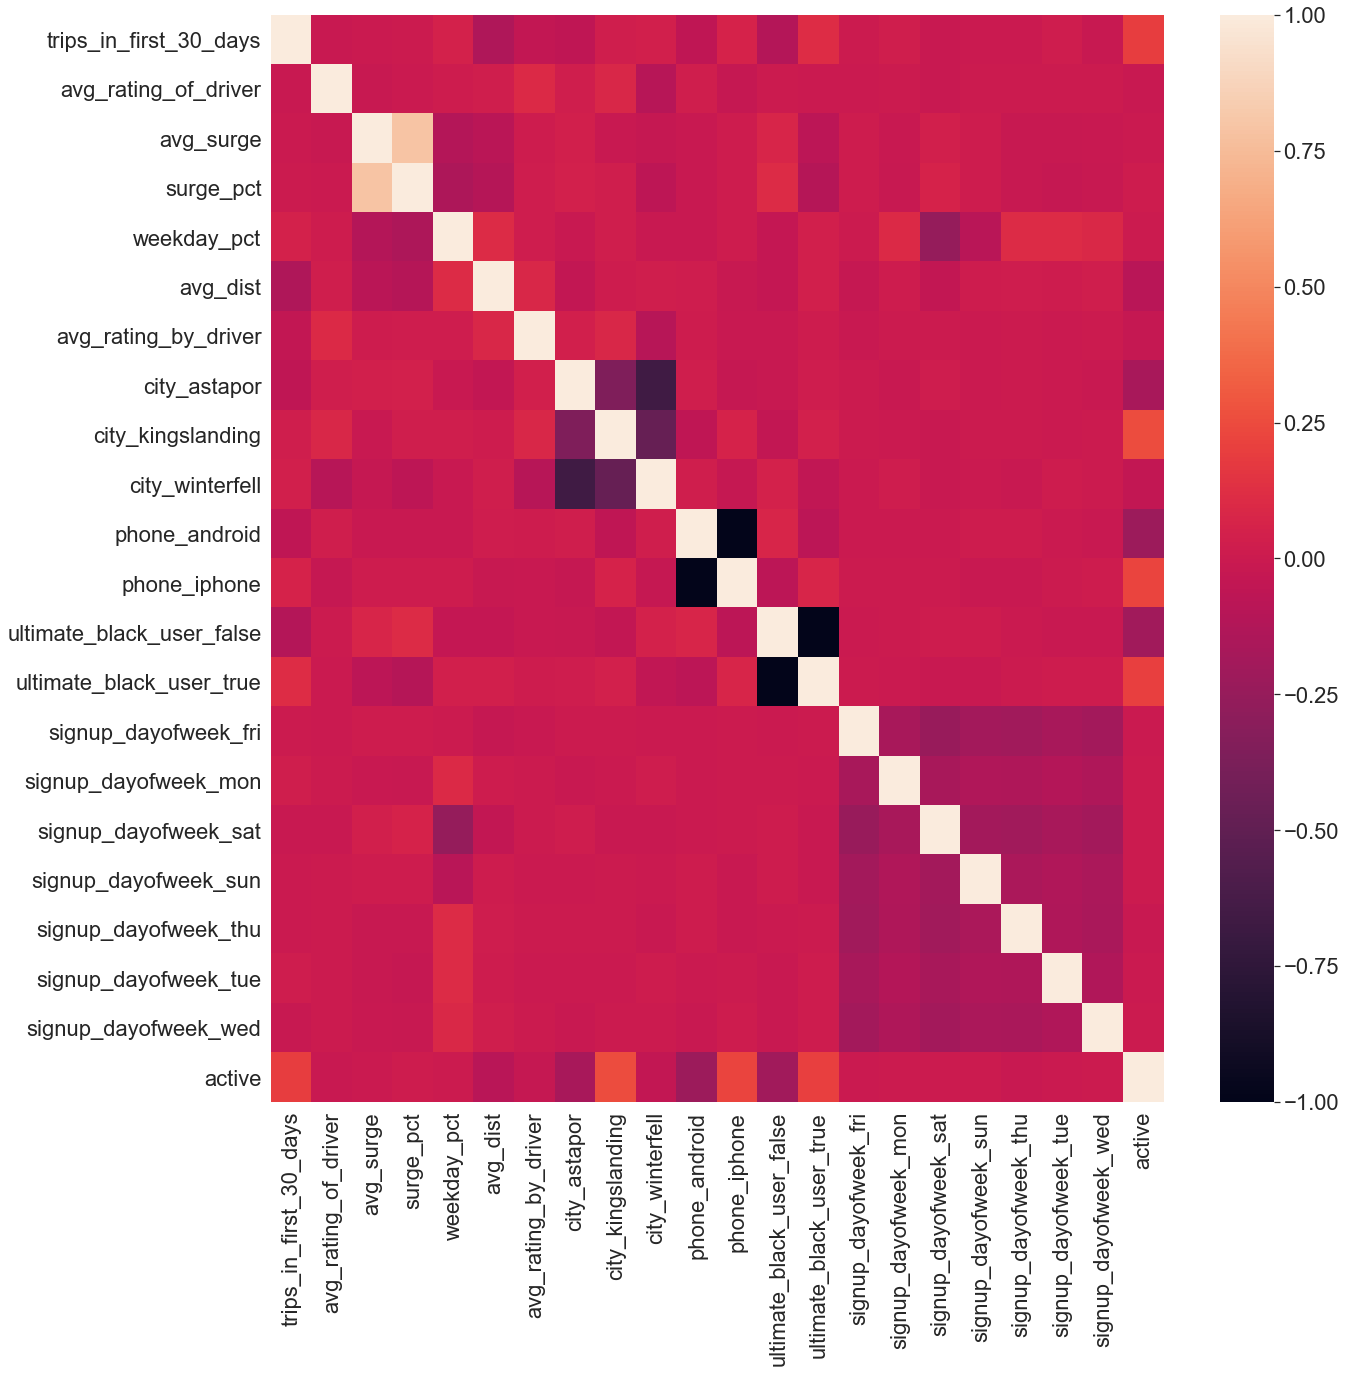

In [25]:
f, a = plt.subplots(1, 1, figsize=(20, 20))
_ = sns.heatmap(data.corr())

# Save our dataset

In [23]:
data.to_csv(OUTPUT_FILE, index=False)